[View in Colaboratory](https://colab.research.google.com/github/sungreong/Pymc3_bayseian/blob/master/discrete_prior_and_Arbitrary_Deterministic_&_Distributions_,_GLM_.ipynb)

In [0]:
!pip install git+https://github.com/pymc-devs/pymc3
!pip install patsy pandas

In [0]:
!pip install pandas-datareader
from pandas_datareader import data

## CASE STUDY 2 : Coal Mining Disasters

변화가 발생할 때의 추정을 하기위해 노력할 것이고 동시에 우리는 missing data 를 다룰지와 다중 샘플을 사용하는 것과 이산형 랜덤변수들로부터 샘플링 하는 것을 해볼 것이다.

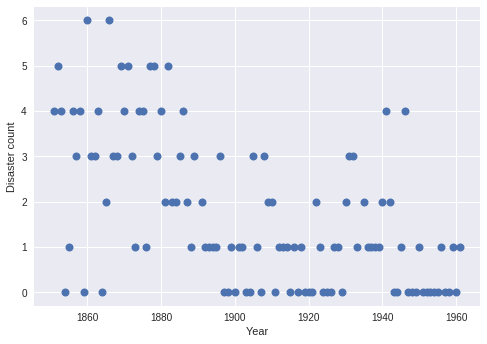

In [3]:
import numpy as np
import matplotlib.pyplot as plt
disaster_data = np.ma.masked_values([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                            3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                            2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
                            1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                            0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                            3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                            0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value=-999)
year = np.arange(1851, 1962)

plt.plot(year, disaster_data, 'o', markersize=8);
plt.ylabel("Disaster count")
plt.xlabel("Year");

시계열 데이터 재난의 발생은 포아송 프로세스를 따른다  우리는 시간대에서 변화하는 위치에 관심을 가지고 완전하게 채굴할 규제를 찾아 보려고 한다.

* D_t = Pois(r_t) , r_t = t 시점에서 재난 포아송 분포의 파라미터  if (t < s) l , else e
*  s ~ unif(t_l , t_h)  s: 변경포인트에서 연 파리미터 변화율
* e ~ exp(1) 변화하기전 파라미터 
*  l : 변경포인트(s) 이후의 파라미터
*  t_l  t_h : t 시점에서의 경계선


포아송과 이산형 uniform 사전분포의 도입과 결정 확률 변수 (rate) 가 참신한 것


In [0]:
import pymc3 as pm
with pm.Model() as disaster_model :
    
    swithpoint = pm.DiscreteUniform("switchpoint" , lower = year.min() , upper= year.max() , testval= 1900)
    
    # 재앙 수 이전과 이후 의 사전확률 분포
    
    early_rate = pm.Exponential("early_rate" , 1)
    late_rate = pm.Exponential("late_rate" , 1)
    
    # 현재 전과 후에 년간 포아송 적절하게 할당하기
    
    rate= pm.math.switch(swithpoint >= year , early_rate , late_rate)
    ## swith를 사용하요 theano에 있는 함수인데, 어떤 year 이후에는  early_rate => late_rate로 변경해줄 수 있다.
    
    disasters = pm.Poisson("disasters" , rate , observed = disaster_data)
    

## 여기선 이상현 변수기 때문에 gradient는 의미가 없다.
* 그래서 우리는 NUTS 를 사용할수 없다. 대신에 우리는 Metropolis step 알고리즘을 사용한다 . 
* adaptive Metropolis-Hastings 시행할 것이다. 자동으로 pymc3는 옳은 샘플링 기법을 지정해준다 

In [7]:
with disaster_model :
    trace = pm.sample(10000)

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate_log__, early_rate_log__]
100%|██████████| 10500/10500 [00:12<00:00, 844.80it/s]
/usr/local/lib/python2.7/dist-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/usr/local/lib/python2.7/dist-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7315fd68d0>,
      dtype=object)

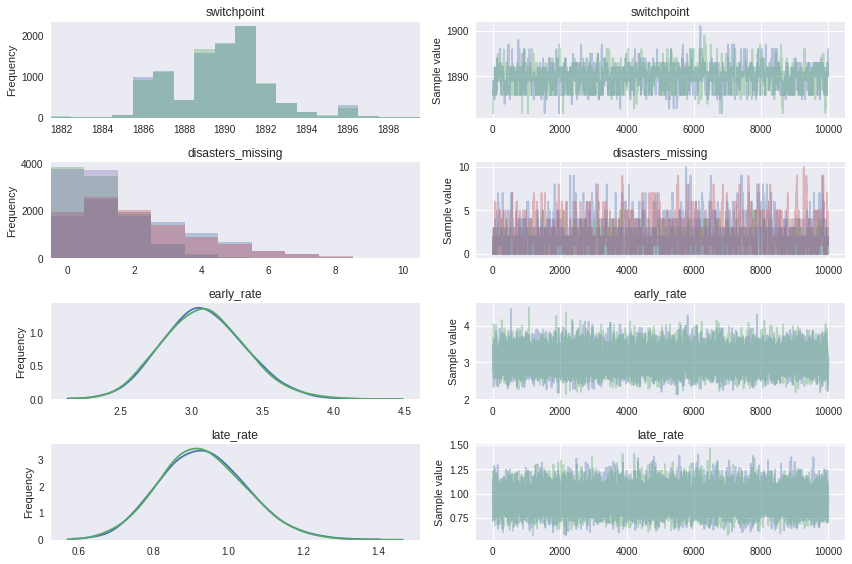

In [8]:
pm.traceplot(trace)

## traceplot 
* 우리는 10년 기간동안의 완전에 관현 중요한 변화를 알아낼 수 있다. 
* 분포가 들쭉날쭉한 것은 스위치포인트와 가능도 함수 사이에 관계가 점핑이 발생하기 떄문이지
* 샘플링 에러때문은 아니다

## Arbitrary deterministics

* Theano 의존하고 있기 때문에 pymc3는 확률변수를  새로운 확률변수로 변형시키는 많은 수학적 연산 함수를 제공한다. 
* 그러나 모든 것이 잇는 것은 아니므로 새로운 임으의 함수도 만들 수 있어야 한다.
 *  **as_op** 를 이용하면 할 수 있다. 
 *  itypes (인풋) otypes(아웃풋) 에 의해 할 수 있다. 

In [0]:
import theano.tensor as tt
from theano.compile.ops import as_op

@as_op(itypes=[tt.lscalar] , otypes = [tt.lscalar])

def crazy_modulo3(value) :
    if value > 0 :
        return value % 3
    else :
        return (-value + 1) % 3
    
with pm.Model() as model_deterministic :
    a = pm.Poisson("a", 1)
    b= crazy_modulo3(a)

In [12]:
with model_deterministic :
    trace = pm.sample(10000)

Sequential sampling (2 chains in 1 job)
Metropolis: [a]
100%|██████████| 10500/10500 [00:01<00:00, 8590.51it/s]
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f730508d050>,
      dtype=object)

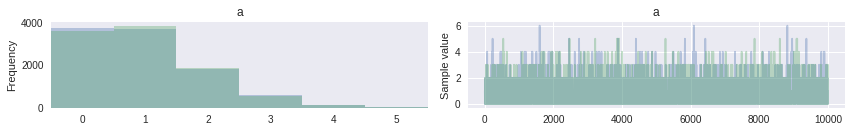

In [13]:
pm.traceplot(trace)

## Arbitrary Distributions 
* 기본적인 것은 많이 제공해주지만 새로운 것을 만들 수 있다. **DensityDist** 를 이용하면 **logP(x)** 로 계산가능한 함수를 만들 수 있다.

In [17]:
import theano.tensor as tt

with pm.Model() as model:
    alpha = pm.Uniform('intercept', -100, 100)

    # Create custom densities
    beta = pm.DensityDist('beta', lambda value: -1.5 * tt.log(1 + value**2), testval=0)
    eps = pm.DensityDist('eps', lambda value: -tt.log(tt.abs_(value)), testval=1)

    # Create likelihood
    like = pm.Normal('y_est', mu=alpha + beta * X, sd=eps, observed=Y)

NameError: ignored

In [0]:

class Beta(pm.Continuous):
    def __init__(self, mu, *args, **kwargs):
        super(Beta, self).__init__(*args, **kwargs)
        self.mu = mu
        self.mode = mu

    def logp(self, value):
        mu = self.mu
        return beta_logp(value - mu)


def beta_logp(value):
    return -1.5 * np.log(1 + (value)**2)


with pm.Model() as model:
    beta = Beta('slope', mu=0, testval=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [slope]
100%|██████████| 10500/10500 [00:05<00:00, 1856.71it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f730b1787d0>,
      dtype=object)

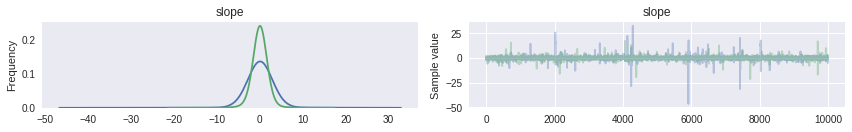

In [20]:
with model :
    trace = pm.sample(10000)

pm.traceplot(trace)

# GLM = Generalized Linear Models 
* pandas DataFrame이 필요하다

In [29]:
import pandas
X1= [1,2,3,5,1,2,3,4,5,1,2,4,5,1]
X2= [4,5,6,1,3,4,5,6,1,2,5,7,8,9]
Y=  [0,1,1,4,5,2,3,4,5,1,2,3,4,5]
df = pandas.DataFrame({'x1': X1, 'x2': X2, 'y': Y})
df

,x1,x2,y
0,1,4,0
1,2,5,1
2,3,6,1
3,5,1,4
4,1,3,5
5,2,4,2
6,3,5,3
7,4,6,4
8,5,1,5
9,1,2,1


In [25]:
from pymc3.glm import GLM

with pm.Model() as model_glm:
    GLM.from_formula('y ~ x1 + x2', df)
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_log__, x2, x1, Intercept]
 88%|████████▊ | 875/1000 [00:42<00:06, 20.82it/s]

100%|██████████| 1000/1000 [00:44<00:00, 22.23it/s]
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 105 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f72fc9dce50>,
      dtype=object)

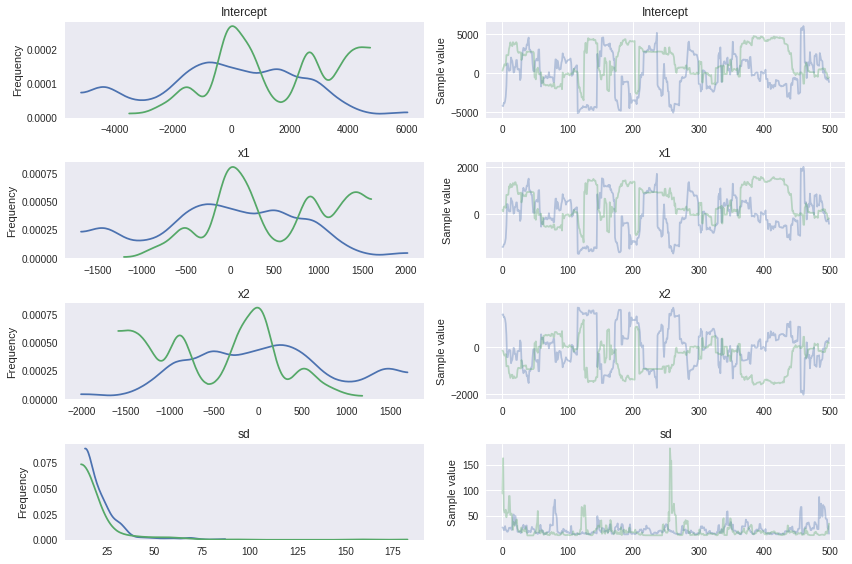

In [26]:
pm.traceplot(trace)

## error distribution

* 우리가 딱히 설정을 안하게 되면 default Normal 이 된다
*logistic regression 에서는 Binomial 족으로 수정해서 해볼 것이다.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [x1, Intercept]
100%|██████████| 1500/1500 [00:01<00:00, 756.02it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f72f9ebd5d0>,
      dtype=object)

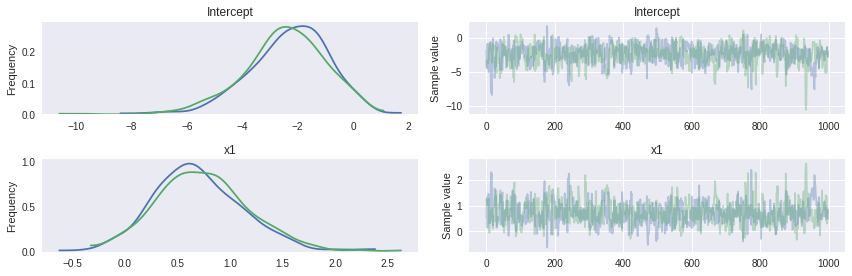

In [30]:
from pymc3.glm.families import Binomial


df_logistic = pandas.DataFrame({"x1" : X1 , "y" : Y > np.median(Y)})

with pm.Model() as model_glm_logistic :
    GLM.from_formula("y~x1", df_logistic , family=Binomial())
    trace = pm.sample(1000)
    
pm.traceplot(trace)